Libraries

In [74]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.utils import resample
from sklearn.ensemble import AdaBoostClassifier
import xgboost as xgb

Data Import

In [75]:
data = pd.read_csv("data/Loan_status_2007-2020Q3.gzip", index_col=0)

/var/folders/p5/qzpvt10n3xl95s2g2sx_w5c00000gn/T/ipykernel_40620/882422459.py:1: DtypeWarning: Columns (1,48,58,117,127,128,129,132,133,134,137) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv("data/Loan_status_2007-2020Q3.gzip", index_col=0)


Data Processing/EDA

In [76]:
data_subset = data[["loan_amnt", "term", "int_rate", "grade", "sub_grade", "home_ownership", "purpose", "dti", "loan_status", "revol_bal"]].dropna()
data_subset["loan_status"] = np.where((data_subset["loan_status"] == "Fully Paid") | (data_subset["loan_status"] == "Current"), 0, 1)
data_subset[["term", "grade", "sub_grade", "home_ownership", "purpose"]] = data_subset[["term", "grade", "sub_grade", "home_ownership", "purpose"]].apply(LabelEncoder().fit_transform)
data_subset["int_rate"] = data_subset["int_rate"].str.strip("%")
data_subset["int_rate"] = (data_subset["int_rate"].astype('float64'))/100

In [20]:
data_subset.head()
data_subset.shape

(2922384, 10)

In [33]:
validation_data = data_subset.sample(20000)

In [36]:
data_subset.shape

(2606905, 10)

In [37]:
validation_data.shape

(20000, 10)

<Axes: title={'center': 'Ratio of loan types'}, ylabel='Type'>

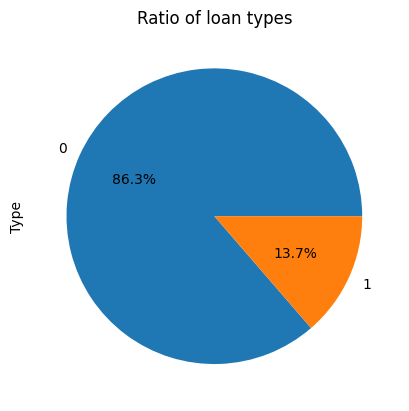

In [38]:
data_subset.groupby('loan_status').size().plot(kind='pie',
                                               y='loan_status',
                                               label='Type',
                                               title='Ratio of loan types',
                                               autopct='%1.1f%%')

In [39]:
well_performing_loans = data_subset[data_subset["loan_status"] == 0]
poor_performing_loans = data_subset[data_subset["loan_status"] == 1]


In [69]:
wpl_downsample = resample(well_performing_loans,
                          replace=True,
                          n_samples=int(len(poor_performing_loans)*1.5),
                          random_state=63)
print(wpl_downsample.shape)

(533953, 10)


In [70]:
data_downsampled = pd.concat([wpl_downsample, poor_performing_loans])
data_downsampled.size

8899220

<Axes: title={'center': 'Ratio of loan types: post downsampling'}, ylabel='Type'>

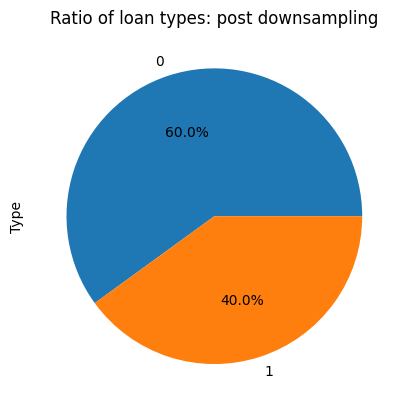

In [71]:
data_downsampled.groupby('loan_status').size().plot(kind='pie',
                                               y='loan_status',
                                               label='Type',
                                               title='Ratio of loan types: post downsampling',
                                               autopct='%1.1f%%')

In [72]:
X = data_downsampled.drop("loan_status", axis = 1)
y = data_downsampled["loan_status"]
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size = 0.2, random_state = 42)
Val_X = validation_data.drop("loan_status", axis = 1)
Val_y = validation_data["loan_status"]

In [77]:
X_ns = data_subset.drop("loan_status", axis=1)
y_ns = data_subset["loan_status"]
X_train_ns, X_test_ns, y_train_ns, y_test_ns = train_test_split(
    X_ns, y_ns, test_size = 0.2, random_state = 42)

Model Building/Evaluation

In [78]:
DT_ns = DecisionTreeClassifier()
DT_ns.fit(X_train_ns, y_train_ns)
DT_ns_pred = DT_ns.predict(X_test_ns)

RF_ns = RandomForestClassifier()
RF_ns.fit(X_train_ns, y_train_ns)
RF_ns_pred = RF_ns.predict(X_test_ns)

print(f"Decision Tree test results without DS:\n{classification_report(y_test_ns, DT_ns_pred)})")
print(f"Random Forest test results without DS:\n{classification_report(y_test_ns, RF_ns_pred)})")

Decision Tree test results without DS:
              precision    recall  f1-score   support

           0       0.88      0.86      0.87    505162
           1       0.21      0.23      0.22     79315

    accuracy                           0.78    584477
   macro avg       0.54      0.55      0.54    584477
weighted avg       0.79      0.78      0.78    584477
)
Random Forest test results without DS:
              precision    recall  f1-score   support

           0       0.87      0.99      0.92    505162
           1       0.38      0.05      0.09     79315

    accuracy                           0.86    584477
   macro avg       0.63      0.52      0.51    584477
weighted avg       0.80      0.86      0.81    584477
)


In [80]:
DT_ns_val = DT_ns.predict(Val_X)
RF_ns_val = RF_ns.predict(Val_X)

print(f"Decision Tree Validation results:\n{classification_report(Val_y, DT_ns_val)})")
print(f"Random Forest Validation results:\n{classification_report(Val_y, RF_ns_val)})")

Decision Tree Validation results:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98     17278
           1       0.83      0.85      0.84      2722

    accuracy                           0.96     20000
   macro avg       0.91      0.91      0.91     20000
weighted avg       0.96      0.96      0.96     20000
)
Random Forest Validation results:
              precision    recall  f1-score   support

           0       0.97      1.00      0.98     17278
           1       0.98      0.81      0.89      2722

    accuracy                           0.97     20000
   macro avg       0.98      0.91      0.94     20000
weighted avg       0.97      0.97      0.97     20000
)


In [81]:
DT = DecisionTreeClassifier()
DT.fit(X_train, y_train)
DT_y_pred = DT.predict(X_test)

RF = RandomForestClassifier(n_estimators = 100)
RF.fit(X_train, y_train)
RF_y_pred = RF.predict(X_test)

# Model Evaluation
print(f"Decision Tree test results with DS:\n{classification_report(y_test, DT_y_pred)})")
print(f"Random Forest test results with DS:\n{classification_report(y_test, RF_y_pred)})")

Decision Tree test results with DS:
              precision    recall  f1-score   support

           0       0.69      0.70      0.70    106803
           1       0.54      0.52      0.53     71182

    accuracy                           0.63    177985
   macro avg       0.61      0.61      0.61    177985
weighted avg       0.63      0.63      0.63    177985
)
Random Forest test results with DS:
              precision    recall  f1-score   support

           0       0.72      0.79      0.75    106803
           1       0.62      0.53      0.57     71182

    accuracy                           0.68    177985
   macro avg       0.67      0.66      0.66    177985
weighted avg       0.68      0.68      0.68    177985
)


In [56]:
DT_val_pred = DT.predict(Val_X)
RF_val_pred = RF.predict(Val_X)

print(f"Decision Tree results:\n{classification_report(Val_y, DT_val_pred)})")
print(f"Random Forest results:\n{classification_report(Val_y, RF_val_pred)})")

Decision Tree results:
              precision    recall  f1-score   support

           0       0.90      0.58      0.70     17278
           1       0.18      0.58      0.27      2722

    accuracy                           0.58     20000
   macro avg       0.54      0.58      0.49     20000
weighted avg       0.80      0.58      0.65     20000
)
Random Forest results:
              precision    recall  f1-score   support

           0       0.92      0.62      0.74     17278
           1       0.22      0.68      0.33      2722

    accuracy                           0.63     20000
   macro avg       0.57      0.65      0.54     20000
weighted avg       0.83      0.63      0.69     20000
)


In [82]:
XGB = xgb.XGBClassifier(n_estimators = 100)
Ada = AdaBoostClassifier(n_estimators=100)

XGB.fit(X_train, y_train)
XGB_pred = XGB.predict(X_test)

Ada.fit(X_train, y_train)
Ada_pred = Ada.predict(X_test)

print(f"XGBoost results:\n{classification_report(y_test, XGB_pred)})")
print(f"AdaBoost results:\n{classification_report(y_test, Ada_pred)})")

XGBoost results:
              precision    recall  f1-score   support

           0       0.71      0.79      0.75    106803
           1       0.62      0.52      0.57     71182

    accuracy                           0.68    177985
   macro avg       0.67      0.66      0.66    177985
weighted avg       0.68      0.68      0.68    177985
)
AdaBoost results:
              precision    recall  f1-score   support

           0       0.70      0.82      0.75    106803
           1       0.63      0.47      0.54     71182

    accuracy                           0.68    177985
   macro avg       0.66      0.64      0.64    177985
weighted avg       0.67      0.68      0.67    177985
)


In [83]:
Ada_val_pred = Ada.predict(Val_X)
XGB_val_pred = XGB.predict(Val_X)

print(f"XGB results:\n{classification_report(Val_y, XGB_val_pred)})")
print(f"ADA results:\n{classification_report(Val_y, Ada_val_pred)})")

XGB results:
              precision    recall  f1-score   support

           0       0.91      0.79      0.85     17278
           1       0.28      0.52      0.37      2722

    accuracy                           0.76     20000
   macro avg       0.60      0.66      0.61     20000
weighted avg       0.83      0.76      0.78     20000
)
ADA results:
              precision    recall  f1-score   support

           0       0.91      0.82      0.86     17278
           1       0.28      0.46      0.35      2722

    accuracy                           0.77     20000
   macro avg       0.59      0.64      0.61     20000
weighted avg       0.82      0.77      0.79     20000
)
